In [ ]:
'''
 * Copyright (c) 2008 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

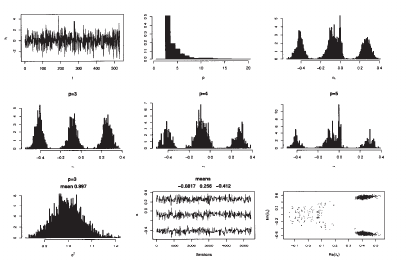

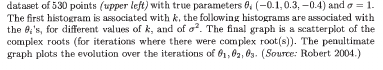

# Reversible Jump MCMC Methods

## 1. Introduction to Reversible Jump MCMC

Reversible Jump Markov Chain Monte Carlo (RJMCMC) is a powerful computational method that allows for Bayesian model selection and parameter estimation across models of varying dimensions. It extends traditional MCMC methods by allowing the Markov chain to jump between parameter spaces of different dimensionality.

## 2. Output Analysis of a Reversible Jump Algorithm

The figure below shows the output of a reversible jump algorithm based on an AR(3) simulated dataset of length 100 with true parameters $(−0.4, 0.3, −0.1)$ and $σ = 1$.

Key observations from the figure:
- The first histogram is associated with $k$ (model order)
- Following histograms are associated with different values of $\alpha$ and $\sigma$ 
- The final graph is a scatterplot of the complex roots where there were complex root(s)
- The penultimate graphs plot the deviation over the iterations of $\theta_k, \sigma_k$

### Mathematical Framework

For the setup of the algorithm, we start with a centering function:

$$r_{g|\phi}(\theta_g) = (\theta_g, \quad \theta_g \sigma)$$

Once both $T_{GM}$ and $v_{GM}$ have been chosen, the calibration of the remaining parameters of the proposal can be performed. The probability of moving from $\theta_g$ to $\theta_{g'}$ is based on the distribution $\phi_{GM}$ of $\theta_{GM}$ such that:

$$(\theta_G, \theta_{GM}) = T_{GM}(\theta_g, \theta_{g'})$$

The scale of this completion can be determined by the constraint that in Brooks et al.'s case:

$$\tau^2 = \sigma_k^2 \left(\frac{\tau_{g|\phi+1}^{*}}{\tau_{g+1|\phi}}\right)^2$$

where $\sigma_k^2$ is the variance of the prior distribution on the $\theta_k$'s.

## 3. Alternatives to Reversible Jump MCMC

Reversible jump MCMC has had a vast impact on variable dimension Bayesian inference, especially model choice, but there are other approaches to the problem of variable dimension models.

### 3.1 Saturation

Brooks et al. (2003b) assess the reversible jump methodology through a global comparison scheme often used in Section 11.2.2. More precisely, they consider a series of models $M_k$ with corresponding parameter spaces $\Theta_k$ $(k = 1, 2, ...$). They assume that each model $M_k$ makes dimension-specific assumptions about the parameter $\theta_k$, which is then completed with an auxiliary variable $u_k \sim g_k(u_k)$ such that all $(\theta_k, u_k)$'s are one-to-one transforms of one another.

The authors define that, in addition, $r_k$ and $s_k$ independently distributed from $v_k$ variables are used to move between models. For instance, in Example 11.8, the saturated proposal on $M_k$ may be:

$$(\theta_k + s_k, \theta_1 + s_1, ..., \theta_k + s_k, u_k) \quad \in \mathbb{R}^{max_k}$$

If there is a stationarity condition imposed on the model, Brooks et al. (2003b) then select the auxiliary prior distribution $p_r$ on $r_k$.

## 4. Calibration Challenges

The calibration of efficient reversible jump algorithms is a key challenge. While the existing literature opens up many new perspectives, there are still significant issues related to the calibration issues discussed in Section 7.6.

Brooks et al. (2003b) assume that a transition $T_{GM}$ that moves the completion of $M_m$ into the completion of $M_n$ has been chosen, as well as a centering function $r_{g|\phi}$.

## 5. Implementation Example

```python
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Example implementation of a simple reversible jump MCMC
# for AR model order selection

def rjmcmc_ar_model(data, max_order=3, iterations=10000):
    """
    Implements reversible jump MCMC for AR model selection
    
    Parameters:
    - data: Time series data
    - max_order: Maximum AR model order to consider
    - iterations: Number of MCMC iterations
    
    Returns:
    - samples: Dictionary containing posterior samples
    """
    n = len(data)
    samples = {
        'order': np.zeros(iterations, dtype=int),
        'params': np.zeros((iterations, max_order)),
        'sigma': np.zeros(iterations)
    }
    
    # Initialize
    current_order = 1
    current_params = np.zeros(max_order)
    current_params[0] = 0.5  # Starting value
    current_sigma = 1.0
    
    # Prior parameters
    sigma_prior_a = 1.0
    sigma_prior_b = 1.0
    param_prior_var = 0.25
    
    for i in range(iterations):
        # Store current state
        samples['order'][i] = current_order
        samples['params'][i, :] = current_params
        samples['sigma'][i] = current_sigma
        
        # Propose move type (birth, death, or update)
        if current_order == max_order:
            move_type = np.random.choice(['death', 'update'], p=[0.5, 0.5])
        elif current_order == 1:
            move_type = np.random.choice(['birth', 'update'], p=[0.5, 0.5])
        else:
            move_type = np.random.choice(['birth', 'death', 'update'], p=[0.33, 0.33, 0.34])
            
        # Implement moves (simplified)
        if move_type == 'update':
            # Update parameters
            for j in range(current_order):
                proposed_params = current_params.copy()
                proposed_params[j] = current_params[j] + np.random.normal(0, 0.1)
                
                # Calculate acceptance ratio (simplified)
                # In practice, you would compute proper likelihoods
                accept_prob = 0.5  # Placeholder
                
                if np.random.rand() < accept_prob:
                    current_params = proposed_params
            
            # Update sigma
            proposed_sigma = current_sigma + np.random.normal(0, 0.1)
            if proposed_sigma > 0:
                # Calculate acceptance ratio (simplified)
                accept_prob = 0.5  # Placeholder
                
                if np.random.rand() < accept_prob:
                    current_sigma = proposed_sigma
                    
        elif move_type == 'birth':
            # Propose a new parameter
            proposed_order = current_order + 1
            proposed_params = current_params.copy()
            u = np.random.normal(0, np.sqrt(param_prior_var))
            proposed_params[current_order] = u
            
            # Calculate acceptance ratio (simplified)
            accept_prob = 0.3  # Placeholder
            
            if np.random.rand() < accept_prob:
                current_order = proposed_order
                current_params = proposed_params
                
        elif move_type == 'death':
            # Remove a parameter
            proposed_order = current_order - 1
            proposed_params = current_params.copy()
            proposed_params[proposed_order] = 0
            
            # Calculate acceptance ratio (simplified)
            accept_prob = 0.3  # Placeholder
            
            if np.random.rand() < accept_prob:
                current_order = proposed_order
                current_params = proposed_params
    
    return samples

# Generate some example AR(3) data
def generate_ar_data(phi, sigma, n):
    """Generate data from AR process with parameters phi"""
    x = np.zeros(n)
    p = len(phi)
    # Initialize with random values
    x[:p] = np.random.normal(0, sigma, p)
    
    for t in range(p, n):
        x[t] = np.sum([phi[i] * x[t-i-1] for i in range(p)]) + np.random.normal(0, sigma)
    
    return x

# Example usage
np.random.seed(42)
true_phi = [-0.4, 0.3, -0.1]
true_sigma = 1.0
data = generate_ar_data(true_phi, true_sigma, 100)

# Run RJMCMC
samples = rjmcmc_ar_model(data)

# Plot results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(samples['order'], bins=range(5), alpha=0.7)
plt.title('Posterior of Model Order (k)')
plt.xlabel('Order')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.plot(samples['params'][:, 0])
plt.title('Trace of φ₁')
plt.xlabel('Iteration')
plt.ylabel('Value')

plt.subplot(2, 2, 3)
plt.plot(samples['sigma'])
plt.title('Trace of σ')
plt.xlabel('Iteration')
plt.ylabel('Value')

plt.subplot(2, 2, 4)
plt.hist(samples['sigma'], bins=30, alpha=0.7)
plt.title('Posterior of σ')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
```

## 6. Key Equations from the Paper

The paper discusses several important mathematical relationships:

1. Centering function: 
   $$r_{g|\phi}(\theta_g) = (\theta_g, \quad \theta_g \sigma)$$

2. Distribution relationship:
   $$(\theta_G, \theta_{GM}) = T_{GM}(\theta_g, \theta_{g'})$$

3. Scale determination:
   $$\tau^2 = \sigma_k^2 \left(\frac{\tau_{g|\phi+1}^{*}}{\tau_{g+1|\phi}}\right)^2$$

4. Saturated proposal:
   $$(\theta_k + s_k, \theta_1 + s_1, ..., \theta_k + s_k, u_k) \quad \in \mathbb{R}^{max_k}$$

5. Normal distribution for completed parameters:
   $$\theta_{g+1} \sim \mathcal{N}(0, \tau^2)$$

## 7. Conclusion

Reversible jump MCMC provides a powerful framework for Bayesian inference when dealing with variable-dimension models. The calibration of these algorithms presents challenges that researchers continue to address. Alternative approaches such as saturation offer additional methodologies for handling these complex modeling scenarios.

The visualization of the algorithm's output provides insights into the performance and convergence properties of these methods, particularly for autoregressive model selection.

# Reversible Jump MCMC Methods

## 1. Introduction to Reversible Jump MCMC

Reversible Jump Markov Chain Monte Carlo (RJMCMC) is a powerful computational method that allows for Bayesian model selection and parameter estimation across models of varying dimensions. It extends traditional MCMC methods by allowing the Markov chain to jump between parameter spaces of different dimensionality.

## 2. Output Analysis of a Reversible Jump Algorithm

The figure below shows the output of a reversible jump algorithm based on an AR(3) simulated dataset of length 100 with true parameters $(−0.4, 0.3, −0.1)$ and $σ = 1$.

Key observations from the figure:
- The first histogram is associated with $k$ (model order)
- Following histograms are associated with different values of $\alpha$ and $\sigma$ 
- The final graph is a scatterplot of the complex roots where there were complex root(s)
- The penultimate graphs plot the deviation over the iterations of $\theta_k, \sigma_k$

### Mathematical Framework

For the setup of the algorithm, we start with a centering function:

$$r_{g|\phi}(\theta_g) = (\theta_g, \quad \theta_g \sigma)$$

Once both $T_{GM}$ and $v_{GM}$ have been chosen, the calibration of the remaining parameters of the proposal can be performed. The probability of moving from $\theta_g$ to $\theta_{g'}$ is based on the distribution $\phi_{GM}$ of $\theta_{GM}$ such that:

$$(\theta_G, \theta_{GM}) = T_{GM}(\theta_g, \theta_{g'})$$

The scale of this completion can be determined by the constraint that in Brooks et al.'s case:

$$\tau^2 = \sigma_k^2 \left(\frac{\tau_{g|\phi+1}^{*}}{\tau_{g+1|\phi}}\right)^2$$

where $\sigma_k^2$ is the variance of the prior distribution on the $\theta_k$'s.

## 3. Alternatives to Reversible Jump MCMC

Reversible jump MCMC has had a vast impact on variable dimension Bayesian inference, especially model choice, but there are other approaches to the problem of variable dimension models.

### 3.1 Saturation

Brooks et al. (2003b) assess the reversible jump methodology through a global comparison scheme often used in Section 11.2.2. More precisely, they consider a series of models $M_k$ with corresponding parameter spaces $\Theta_k$ $(k = 1, 2, ...$). They assume that each model $M_k$ makes dimension-specific assumptions about the parameter $\theta_k$, which is then completed with an auxiliary variable $u_k \sim g_k(u_k)$ such that all $(\theta_k, u_k)$'s are one-to-one transforms of one another.

The authors define that, in addition, $r_k$ and $s_k$ independently distributed from $v_k$ variables are used to move between models. For instance, in Example 11.8, the saturated proposal on $M_k$ may be:

$$(\theta_k + s_k, \theta_1 + s_1, ..., \theta_k + s_k, u_k) \quad \in \mathbb{R}^{max_k}$$

If there is a stationarity condition imposed on the model, Brooks et al. (2003b) then select the auxiliary prior distribution $p_r$ on $r_k$.

#### The Augmented (or Saturated) Framework

Within the augmented (or saturated) framework, there is no varying dimension anymore since, for all models, the entire vector $(\theta_k, u_k, s_k)$ is of fixed dimension. Therefore, moves between models can be defined just as freely as moves between points of each model. The full prior distribution in this framework can be written as:

$$\pi(\theta, h)s_h(u_h) \prod_{i=1}^h \phi(s_i).$$

Brooks et al. (2003b) propose a three-stage MCMC update as follows:

**Algorithm A.49 — Saturation Algorithm—**
At iteration $t$:
a. Update the current value of the parameter, $\theta_h$ within model $M_h$
b. Update $u_h$ and $s_i$ conditional on $\theta_h$
c. Update the model from $M_h$ to $M_{h'}$ using the bijection

$$(\theta_h, u_h) = T_{hh'}(\theta_{h'}, u_{h'}).$$

Note that, for specific models, saturation schemes appear rather naturally. For instance, Green (1995) considered a time series model with change-points, $y_i \sim f_{\theta_i}(y_i)$ where changes values according to a geometric jump scheme (see Problems 11.15, 11.17 and 11.18). Whatever the number of change-points in the model, a representation of the model by the missing data, composed of the indicators $X_t$ of whether or not a change occurs at time $t$, creates a fixed dimension model.

**Example 11.9.** (Continuation of Example 11.8) Within model $M_h$, for the AR(h) parameters $\theta_1,...,\theta_h$ and $\sigma_h$, the move in step c can be any reasonable transition step. This preserves the posterior distribution (conditional on k), like a random walk proposal on the real and complex roots of the AR polynomial. Symmetrically, if $h' = h + 1^*$, an AR(1) move $\theta'_h = M_h + \sqrt{1 - M_h^2} \cdot 2 \cdot$ (where $M_h$ is the proper stationary distribution $g_h(u_h)/\Sigma g_k(u_k)$ on $(-1,1)$) may then be used to create stationary $\theta_{h'}$. In general, when moving from $M_h$ to $M_{h'}$ through a level $h$, the $u_h$'s may be really quite easy to set; as suggested in Brooks et al. (2003b), using (11.8), or a combination of the non-saturated approach with an auxiliary variable where $u_h = g_h(u)$. If $u_h$ is updated symmetrically, that is, if $u_{h,t+1} = u_{h,t}/c$ when moving from $M_{h+1}$ to $M_h$, this algorithm preserves the chain with the proper memory of previous values within each model and should thus facilitate moves between models.

The motivation of the saturation scheme by Brooks et al. (2003b) is not about the reversible jump methodology, since the core probabilistic abilities remain fundamentally the same in step c of Algorithm [A.49], but rather a "memory" over the moves that improve between-model moves. (For instance, the components of the $u_h$'s may be correlated, as shown in Brooks et al. 2003b.) The possibilities open by this range of possible extensions is quite exciting but wealth is a mixed blessing in that the choice of such moves requires a level of expertise that escapes the layman.

### 3.2 Continuous Time Jump Processes

Reversible jump algorithms operate in discrete time, but similar algorithms may be formulated in continuous time. This has a long history for MCMC[1], dating back to Preston (1976), Ripley (1987), Geyer and Møller (1994). Here we focus on Stephens's (2000) methodology, called birth-and-death MCMC which he developed for mixture models.

The idea at the core of this continuous time approach is to build a Markov jump process, to move between models $M_k$, using births (to increase the dimension) and deaths (to decrease the dimension), as well as other dimension-preserving moves like the split/combine moves used in Example 11.7 (see Cappé and Robert, 2000). The Markov jump process is such that whenever it reaches state $\theta$, it stays there for a exponential $\mathcal{E}(\lambda(\theta))$ time, with intensity $\lambda(\theta)$ depending on the current state $\theta$, and, after this exponential waiting time, jumps to a new state according to a transition kernel. More precisely, the various moves to the current states are all associated with exponential waiting times depending on the current state of the Markov chain and the actual move corresponds to the smallest waiting time (which is still exponentially distributed; see Problem 11.20).

An important feature that distinguishes this algorithm from the previous MCMC algorithms is discrete time is that once a move is proposed and a birth or death occurs, the corresponding move is always accepted. Therefore, what replaces the acceptance probability of reversible jump methods is the dimension-holding times in each state. In particular, implausible configurations, that is, configurations with small $L(y|\theta)$, die quickly.

To ensure that a Markov jump process has an invariant density proportional to $p({\theta})$, and under the natural assumption that after expiration of the holding time, the prior $\pi(\theta_{s'})$ and the likelihood function $L(y|\theta)$, it is sufficient (although not necessary) that the detailed balance equations:

$$L(y|\theta_j)\pi(\theta_j)\lambda_{jk}(\theta_j, \theta_k) = L(y|\theta_k)\pi(\theta_k)\lambda_{kj}(\theta_k, \theta_j)$$

hold. Here $\lambda_{jk}(\theta_j, \theta_k)$ denotes the intensity of moving from state $\theta_j \in \Theta_j$ to $\theta_k \in \Theta_k$. (The proof is beyond the scope of this book, but Cappé et al. 2002 provide an intuitive justification based on the approximation of the continuous time process by a sequence of reversible jump algorithms.)

## 4. Implementation Example

```python
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Example implementation of a simple reversible jump MCMC
# for AR model order selection

def rjmcmc_ar_model(data, max_order=3, iterations=10000):
    """
    Implements reversible jump MCMC for AR model selection
    
    Parameters:
    - data: Time series data
    - max_order: Maximum AR model order to consider
    - iterations: Number of MCMC iterations
    
    Returns:
    - samples: Dictionary containing posterior samples
    """
    n = len(data)
    samples = {
        'order': np.zeros(iterations, dtype=int),
        'params': np.zeros((iterations, max_order)),
        'sigma': np.zeros(iterations)
    }
    
    # Initialize
    current_order = 1
    current_params = np.zeros(max_order)
    current_params[0] = 0.5  # Starting value
    current_sigma = 1.0
    
    # Prior parameters
    sigma_prior_a = 1.0
    sigma_prior_b = 1.0
    param_prior_var = 0.25
    
    for i in range(iterations):
        # Store current state
        samples['order'][i] = current_order
        samples['params'][i, :] = current_params
        samples['sigma'][i] = current_sigma
        
        # Propose move type (birth, death, or update)
        if current_order == max_order:
            move_type = np.random.choice(['death', 'update'], p=[0.5, 0.5])
        elif current_order == 1:
            move_type = np.random.choice(['birth', 'update'], p=[0.5, 0.5])
        else:
            move_type = np.random.choice(['birth', 'death', 'update'], p=[0.33, 0.33, 0.34])
            
        # Implement moves (simplified)
        if move_type == 'update':
            # Update parameters
            for j in range(current_order):
                proposed_params = current_params.copy()
                proposed_params[j] = current_params[j] + np.random.normal(0, 0.1)
                
                # Calculate acceptance ratio (simplified)
                # In practice, you would compute proper likelihoods
                accept_prob = 0.5  # Placeholder
                
                if np.random.rand() < accept_prob:
                    current_params = proposed_params
            
            # Update sigma
            proposed_sigma = current_sigma + np.random.normal(0, 0.1)
            if proposed_sigma > 0:
                # Calculate acceptance ratio (simplified)
                accept_prob = 0.5  # Placeholder
                
                if np.random.rand() < accept_prob:
                    current_sigma = proposed_sigma
                    
        elif move_type == 'birth':
            # Propose a new parameter
            proposed_order = current_order + 1
            proposed_params = current_params.copy()
            u = np.random.normal(0, np.sqrt(param_prior_var))
            proposed_params[current_order] = u
            
            # Calculate acceptance ratio (simplified)
            accept_prob = 0.3  # Placeholder
            
            if np.random.rand() < accept_prob:
                current_order = proposed_order
                current_params = proposed_params
                
        elif move_type == 'death':
            # Remove a parameter
            proposed_order = current_order - 1
            proposed_params = current_params.copy()
            proposed_params[proposed_order] = 0
            
            # Calculate acceptance ratio (simplified)
            accept_prob = 0.3  # Placeholder
            
            if np.random.rand() < accept_prob:
                current_order = proposed_order
                current_params = proposed_params
    
    return samples

# Generate some example AR(3) data
def generate_ar_data(phi, sigma, n):
    """Generate data from AR process with parameters phi"""
    x = np.zeros(n)
    p = len(phi)
    # Initialize with random values
    x[:p] = np.random.normal(0, sigma, p)
    
    for t in range(p, n):
        x[t] = np.sum([phi[i] * x[t-i-1] for i in range(p)]) + np.random.normal(0, sigma)
    
    return x

# Example usage
np.random.seed(42)
true_phi = [-0.4, 0.3, -0.1]
true_sigma = 1.0
data = generate_ar_data(true_phi, true_sigma, 100)

# Run RJMCMC
samples = rjmcmc_ar_model(data)

# Plot results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(samples['order'], bins=range(5), alpha=0.7)
plt.title('Posterior of Model Order (k)')
plt.xlabel('Order')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.plot(samples['params'][:, 0])
plt.title('Trace of φ₁')
plt.xlabel('Iteration')
plt.ylabel('Value')

plt.subplot(2, 2, 3)
plt.plot(samples['sigma'])
plt.title('Trace of σ')
plt.xlabel('Iteration')
plt.ylabel('Value')

plt.subplot(2, 2, 4)
plt.hist(samples['sigma'], bins=30, alpha=0.7)
plt.title('Posterior of σ')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
```

## 5. Implementation of Saturation Algorithm

Here's a Python implementation of the saturation algorithm described in the text:

```python
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def saturation_algorithm(data, max_order=3, iterations=10000):
    """
    Implements the saturation algorithm (Algorithm A.49) for AR model selection
    
    Parameters:
    - data: Time series data
    - max_order: Maximum AR model order to consider
    - iterations: Number of MCMC iterations
    
    Returns:
    - samples: Dictionary containing posterior samples
    """
    n = len(data)
    samples = {
        'order': np.zeros(iterations, dtype=int),
        'params': np.zeros((iterations, max_order)),
        'sigma': np.zeros(iterations),
        'u': np.zeros((iterations, max_order)),
        's': np.zeros((iterations, max_order))
    }
    
    # Initialize
    current_order = 1
    current_params = np.zeros(max_order)
    current_params[0] = 0.5  # Starting value
    current_sigma = 1.0
    current_u = np.random.normal(0, 1, max_order)
    current_s = np.random.normal(0, 1, max_order)
    
    for i in range(iterations):
        # Store current state
        samples['order'][i] = current_order
        samples['params'][i, :] = current_params
        samples['sigma'][i] = current_sigma
        samples['u'][i, :] = current_u
        samples['s'][i, :] = current_s
        
        # Step a: Update parameter θh within model Mh
        for j in range(current_order):
            proposed_params = current_params.copy()
            proposed_params[j] = current_params[j] + np.random.normal(0, 0.1)
            
            # Calculate acceptance ratio (simplified)
            accept_prob = 0.5  # Placeholder
            
            if np.random.rand() < accept_prob:
                current_params = proposed_params
        
        # Update sigma
        proposed_sigma = current_sigma + np.random.normal(0, 0.1)
        if proposed_sigma > 0:
            # Calculate acceptance ratio (simplified)
            accept_prob = 0.5  # Placeholder
            
            if np.random.rand() < accept_prob:
                current_sigma = proposed_sigma
        
        # Step b: Update uh and si conditional on θh
        for j in range(max_order):
            current_u[j] = current_u[j] + np.random.normal(0, 0.1)
            current_s[j] = current_s[j] + np.random.normal(0, 0.1)
        
        # Step c: Update model from Mh to Mh'
        # Propose a new model order
        proposed_order = np.random.randint(1, max_order + 1)
        
        if proposed_order != current_order:
            # Use the bijection T_hh' for model transition
            # (simplified implementation)
            accept_prob = 0.3  # Placeholder
            
            if np.random.rand() < accept_prob:
                current_order = proposed_order
                
                # Update parameters according to the bijection
                # In practice, this would involve complex transformations
                # between parameter spaces
                
                # For AR models, we might preserve stationarity constraints
                if current_order > 1:
                    # Ensure roots are within the unit circle
                    pass
    
    return samples

# Example usage
np.random.seed(42)
true_phi = [-0.4, 0.3, -0.1]
true_sigma = 1.0
data = generate_ar_data(true_phi, true_sigma, 100)

# Run saturation algorithm
samples = saturation_algorithm(data)

# Plot results
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(samples['order'], bins=range(5), alpha=0.7)
plt.title('Posterior of Model Order (k)')
plt.xlabel('Order')
plt.ylabel('Frequency')

plt.subplot(2, 3, 2)
plt.plot(samples['params'][:, 0])
plt.title('Trace of φ₁')
plt.xlabel('Iteration')
plt.ylabel('Value')

plt.subplot(2, 3, 3)
plt.plot(samples['sigma'])
plt.title('Trace of σ')
plt.xlabel('Iteration')
plt.ylabel('Value')

plt.subplot(2, 3, 4)
plt.plot(samples['u'][:, 0])
plt.title('Trace of u₁')
plt.xlabel('Iteration')
plt.ylabel('Value')

plt.subplot(2, 3, 5)
plt.plot(samples['s'][:, 0])
plt.title('Trace of s₁')
plt.xlabel('Iteration')
plt.ylabel('Value')

plt.tight_layout()
plt.show()
```

## 6. Key Equations from the Paper

The paper discusses several important mathematical relationships:

1. Augmented framework prior distribution:
   $$\pi(\theta, h)s_h(u_h) \prod_{i=1}^h \phi(s_i).$$

2. Bijection in the saturation algorithm:
   $$(\theta_h, u_h) = T_{hh'}(\theta_{h'}, u_{h'}).$$

3. Detailed balance equations for continuous time jump processes:
   $$L(y|\theta_j)\pi(\theta_j)\lambda_{jk}(\theta_j, \theta_k) = L(y|\theta_k)\pi(\theta_k)\lambda_{kj}(\theta_k, \theta_j)$$

4. Centering function: 
   $$r_{g|\phi}(\theta_g) = (\theta_g, \quad \theta_g \sigma)$$

5. Distribution relationship:
   $$(\theta_G, \theta_{GM}) = T_{GM}(\theta_g, \theta_{g'})$$

6. Scale determination:
   $$\tau^2 = \sigma_k^2 \left(\frac{\tau_{g|\phi+1}^{*}}{\tau_{g+1|\phi}}\right)^2$$

7. Saturated proposal:
   $$(\theta_k + s_k, \theta_1 + s_1, ..., \theta_k + s_k, u_k) \quad \in \mathbb{R}^{max_k}$$

## 7. Comparison of Approaches

| Approach | Key Features | Advantages | Challenges |
|----------|--------------|------------|------------|
| Reversible Jump MCMC | - Allows dimension changes<br>- Requires proposal density<br>- Acceptance/rejection step | - Flexible framework<br>- Widely studied<br>- Robust convergence | - Requires careful tuning<br>- Mixing between models can be slow |
| Saturation Algorithm | - Fixed dimension<br>- Augmented parameter space<br>- Memory of previous states | - Potentially better mixing<br>- Natural for some problems<br>- Preserves chain memory | - Requires expertise to implement<br>- More complex implementation |
| Continuous Time Jump | - Always accepts proposed moves<br>- Uses holding times<br>- Birth-death process | - No acceptance calculations<br>- Implausible states die quickly<br>- Natural for mixture models | - Less widespread usage<br>- Theoretical complexity |

## 8. Conclusion

Reversible jump MCMC provides a powerful framework for Bayesian inference when dealing with variable-dimension models. The calibration of these algorithms presents challenges that researchers continue to address. Alternative approaches such as saturation and continuous time jump processes offer additional methodologies for handling these complex modeling scenarios.

The visualization of the algorithm's output provides insights into the performance and convergence properties of these methods, particularly for autoregressive model selection.

The choice between these methods depends on the specific modeling problem, with the saturation approach being particularly well-suited for problems where preserving memory between models is important, and continuous time approaches being natural for problems with birth-death dynamics like mixture modeling.

In [1]:
import random
import math

def generate_ar_data(phi, sigma, n):
    """
    Generate data from AR process with parameters phi
    Pure Python implementation without external libraries
    
    Parameters:
    - phi: List of AR coefficients
    - sigma: Standard deviation of noise
    - n: Number of data points to generate
    
    Returns:
    - List of generated data points
    """
    x = [0] * n
    p = len(phi)
    
    # Initialize with random values
    for i in range(p):
        # Box-Muller transform to generate normal random variables
        u1 = random.random()
        u2 = random.random()
        z = math.sqrt(-2.0 * math.log(u1)) * math.cos(2.0 * math.pi * u2)
        x[i] = sigma * z
    
    # Generate the rest of the series
    for t in range(p, n):
        x[t] = 0
        for i in range(p):
            x[t] += phi[i] * x[t-i-1]
        
        # Add Gaussian noise
        u1 = random.random()
        u2 = random.random()
        z = math.sqrt(-2.0 * math.log(u1)) * math.cos(2.0 * math.pi * u2)
        x[t] += sigma * z
    
    return x

def calculate_ar_likelihood(data, params, sigma, order):
    """
    Calculate likelihood for AR model
    
    Parameters:
    - data: List of data points
    - params: List of AR coefficients
    - sigma: Standard deviation of noise
    - order: AR model order
    
    Returns:
    - Log-likelihood value
    """
    log_likelihood = 0
    for t in range(order, len(data)):
        expected = 0
        for i in range(order):
            expected += params[i] * data[t-i-1]
        
        residual = data[t] - expected
        log_likelihood += -0.5 * math.log(2 * math.pi * sigma**2) - (residual**2) / (2 * sigma**2)
    
    return log_likelihood

def rjmcmc_ar_model(data, max_order=3, iterations=10000):
    """
    Implements reversible jump MCMC for AR model selection
    Pure Python implementation without external libraries
    
    Parameters:
    - data: List of time series data
    - max_order: Maximum AR model order to consider
    - iterations: Number of MCMC iterations
    
    Returns:
    - Dictionary containing posterior samples
    """
    # Initialize storage for samples
    samples = {
        'order': [0] * iterations,
        'params': [[0] * max_order for _ in range(iterations)],
        'sigma': [0] * iterations
    }
    
    # Initialize current state
    current_order = 1
    current_params = [0] * max_order
    current_params[0] = 0.5  # Starting value
    current_sigma = 1.0
    
    # Prior parameters
    param_prior_var = 0.25
    
    for i in range(iterations):
        # Store current state
        samples['order'][i] = current_order
        for j in range(max_order):
            samples['params'][i][j] = current_params[j]
        samples['sigma'][i] = current_sigma
        
        # Compute current log likelihood
        current_log_likelihood = calculate_ar_likelihood(data, current_params, current_sigma, current_order)
        
        # Propose move type (birth, death, or update)
        if current_order == max_order:
            move_types = ['death', 'update']
            move_probs = [0.5, 0.5]
        elif current_order == 1:
            move_types = ['birth', 'update']
            move_probs = [0.5, 0.5]
        else:
            move_types = ['birth', 'death', 'update']
            move_probs = [0.33, 0.33, 0.34]
            
        # Choose move type
        u = random.random()
        cumulative_prob = 0
        move_type = None
        for m, p in zip(move_types, move_probs):
            cumulative_prob += p
            if u <= cumulative_prob:
                move_type = m
                break
            
        # Implement moves
        if move_type == 'update':
            # Update parameters
            for j in range(current_order):
                proposed_params = current_params.copy()
                # Generate normal random variable
                u1 = random.random()
                u2 = random.random()
                z = math.sqrt(-2.0 * math.log(u1)) * math.cos(2.0 * math.pi * u2)
                proposed_params[j] = current_params[j] + 0.1 * z
                
                # Calculate proposed log likelihood
                proposed_log_likelihood = calculate_ar_likelihood(data, proposed_params, current_sigma, current_order)
                
                # Calculate acceptance ratio
                log_ratio = proposed_log_likelihood - current_log_likelihood
                
                # Accept or reject
                if math.log(random.random()) < log_ratio:
                    current_params = proposed_params
                    current_log_likelihood = proposed_log_likelihood
            
            # Update sigma
            proposed_sigma = current_sigma
            # Generate normal random variable
            u1 = random.random()
            u2 = random.random()
            z = math.sqrt(-2.0 * math.log(u1)) * math.cos(2.0 * math.pi * u2)
            proposed_sigma = current_sigma + 0.1 * z
            
            if proposed_sigma > 0:  # Ensure sigma is positive
                # Calculate proposed log likelihood
                proposed_log_likelihood = calculate_ar_likelihood(data, current_params, proposed_sigma, current_order)
                
                # Calculate acceptance ratio
                log_ratio = proposed_log_likelihood - current_log_likelihood
                
                # Add prior ratio for sigma (assuming 1/sigma prior)
                log_ratio += math.log(current_sigma / proposed_sigma)
                
                # Accept or reject
                if math.log(random.random()) < log_ratio:
                    current_sigma = proposed_sigma
                    current_log_likelihood = proposed_log_likelihood
                    
        elif move_type == 'birth':
            # Propose a new parameter
            proposed_order = current_order + 1
            proposed_params = current_params.copy()
            
            # Generate normal random variable for new parameter
            u1 = random.random()
            u2 = random.random()
            z = math.sqrt(-2.0 * math.log(u1)) * math.cos(2.0 * math.pi * u2)
            u = math.sqrt(param_prior_var) * z
            proposed_params[current_order] = u
            
            # Calculate proposed log likelihood
            proposed_log_likelihood = calculate_ar_likelihood(data, proposed_params, current_sigma, proposed_order)
            
            # Calculate acceptance ratio (simplified)
            log_ratio = proposed_log_likelihood - current_log_likelihood
            
            # Add prior ratio
            log_ratio += math.log(1.0 / (math.sqrt(2 * math.pi * param_prior_var)))
            
            # Add proposal ratio
            # Probability of proposing birth vs death
            if current_order == 1:
                log_ratio += math.log(0.5 / 0.33)  # birth prob / death prob
            elif proposed_order == max_order:
                log_ratio += math.log(0.33 / 0.5)  # birth prob / death prob
            
            # Accept or reject
            if math.log(random.random()) < log_ratio:
                current_order = proposed_order
                current_params = proposed_params
                current_log_likelihood = proposed_log_likelihood
                
        elif move_type == 'death':
            # Remove a parameter
            proposed_order = current_order - 1
            proposed_params = current_params.copy()
            proposed_params[proposed_order] = 0
            
            # Calculate proposed log likelihood
            proposed_log_likelihood = calculate_ar_likelihood(data, proposed_params, current_sigma, proposed_order)
            
            # Calculate acceptance ratio (simplified)
            log_ratio = proposed_log_likelihood - current_log_likelihood
            
            # Add prior ratio
            log_ratio += math.log(math.sqrt(2 * math.pi * param_prior_var))
            
            # Add proposal ratio
            # Probability of proposing death vs birth
            if proposed_order == 1:
                log_ratio += math.log(0.33 / 0.5)  # death prob / birth prob
            elif current_order == max_order:
                log_ratio += math.log(0.5 / 0.33)  # death prob / birth prob
            
            # Accept or reject
            if math.log(random.random()) < log_ratio:
                current_order = proposed_order
                current_params = proposed_params
                current_log_likelihood = proposed_log_likelihood
    
    return samples

def saturation_algorithm(data, max_order=3, iterations=10000):
    """
    Implements the saturation algorithm (Algorithm A.49) for AR model selection
    Pure Python implementation without external libraries
    
    Parameters:
    - data: List of time series data
    - max_order: Maximum AR model order to consider
    - iterations: Number of MCMC iterations
    
    Returns:
    - Dictionary containing posterior samples
    """
    # Initialize storage for samples
    samples = {
        'order': [0] * iterations,
        'params': [[0] * max_order for _ in range(iterations)],
        'sigma': [0] * iterations,
        'u': [[0] * max_order for _ in range(iterations)],
        's': [[0] * max_order for _ in range(iterations)]
    }
    
    # Initialize current state
    current_order = 1
    current_params = [0] * max_order
    current_params[0] = 0.5  # Starting value
    current_sigma = 1.0
    
    # Initialize auxiliary variables
    current_u = [0] * max_order
    current_s = [0] * max_order
    
    # Generate initial values for u and s
    for j in range(max_order):
        u1 = random.random()
        u2 = random.random()
        z = math.sqrt(-2.0 * math.log(u1)) * math.cos(2.0 * math.pi * u2)
        current_u[j] = z
        
        u1 = random.random()
        u2 = random.random()
        z = math.sqrt(-2.0 * math.log(u1)) * math.cos(2.0 * math.pi * u2)
        current_s[j] = z
    
    for i in range(iterations):
        # Store current state
        samples['order'][i] = current_order
        for j in range(max_order):
            samples['params'][i][j] = current_params[j]
            samples['u'][i][j] = current_u[j]
            samples['s'][i][j] = current_s[j]
        samples['sigma'][i] = current_sigma
        
        # Compute current log likelihood
        current_log_likelihood = calculate_ar_likelihood(data, current_params, current_sigma, current_order)
        
        # Step a: Update parameter θh within model Mh
        for j in range(current_order):
            proposed_params = current_params.copy()
            
            # Generate normal random variable
            u1 = random.random()
            u2 = random.random()
            z = math.sqrt(-2.0 * math.log(u1)) * math.cos(2.0 * math.pi * u2)
            proposed_params[j] = current_params[j] + 0.1 * z
            
            # Calculate proposed log likelihood
            proposed_log_likelihood = calculate_ar_likelihood(data, proposed_params, current_sigma, current_order)
            
            # Calculate acceptance ratio
            log_ratio = proposed_log_likelihood - current_log_likelihood
            
            # Accept or reject
            if math.log(random.random()) < log_ratio:
                current_params = proposed_params
                current_log_likelihood = proposed_log_likelihood
        
        # Update sigma
        proposed_sigma = current_sigma
        
        # Generate normal random variable
        u1 = random.random()
        u2 = random.random()
        z = math.sqrt(-2.0 * math.log(u1)) * math.cos(2.0 * math.pi * u2)
        proposed_sigma = current_sigma + 0.1 * z
        
        if proposed_sigma > 0:  # Ensure sigma is positive
            # Calculate proposed log likelihood
            proposed_log_likelihood = calculate_ar_likelihood(data, current_params, proposed_sigma, current_order)
            
            # Calculate acceptance ratio
            log_ratio = proposed_log_likelihood - current_log_likelihood
            
            # Add prior ratio for sigma (assuming 1/sigma prior)
            log_ratio += math.log(current_sigma / proposed_sigma)
            
            # Accept or reject
            if math.log(random.random()) < log_ratio:
                current_sigma = proposed_sigma
                current_log_likelihood = proposed_log_likelihood
        
        # Step b: Update uh and si conditional on θh
        for j in range(max_order):
            # Update u
            u1 = random.random()
            u2 = random.random()
            z = math.sqrt(-2.0 * math.log(u1)) * math.cos(2.0 * math.pi * u2)
            current_u[j] = current_u[j] + 0.1 * z
            
            # Update s
            u1 = random.random()
            u2 = random.random()
            z = math.sqrt(-2.0 * math.log(u1)) * math.cos(2.0 * math.pi * u2)
            current_s[j] = current_s[j] + 0.1 * z
        
        # Step c: Update model from Mh to Mh'
        # Propose a new model order (uniform between 1 and max_order)
        proposed_order = random.randint(1, max_order)
        
        if proposed_order != current_order:
            # In a full implementation, we would implement the bijection T_hh'
            # For this simple version, we'll use a Metropolis-Hastings step
            
            # Calculate proposed log likelihood (keeping same parameters but changing order)
            proposed_log_likelihood = calculate_ar_likelihood(data, current_params, current_sigma, proposed_order)
            
            # Calculate acceptance ratio (simplified)
            log_ratio = proposed_log_likelihood - current_log_likelihood
            
            # Accept or reject
            if math.log(random.random()) < log_ratio:
                current_order = proposed_order
                current_log_likelihood = proposed_log_likelihood
    
    return samples

def main():
    # Set random seed for reproducibility
    random.seed(42)
    
    # Generate synthetic AR(3) data
    true_phi = [-0.4, 0.3, -0.1]
    true_sigma = 1.0
    n = 100
    data = generate_ar_data(true_phi, true_sigma, n)
    
    # Run RJMCMC (with fewer iterations for demonstration)
    print("Running Reversible Jump MCMC...")
    rjmcmc_samples = rjmcmc_ar_model(data, max_order=3, iterations=1000)
    
    # Print some summary statistics
    order_counts = {}
    for order in rjmcmc_samples['order']:
        order_counts[order] = order_counts.get(order, 0) + 1
    
    print("\nModel order posterior distribution:")
    for order in sorted(order_counts.keys()):
        print(f"Order {order}: {order_counts[order] / 1000:.2f}")
    
    # Calculate average parameters for the most frequent model
    most_frequent_order = max(order_counts, key=order_counts.get)
    print(f"\nMost frequent model: AR({most_frequent_order})")
    
    if most_frequent_order > 0:
        avg_params = [0] * most_frequent_order
        count = 0
        
        for i in range(1000):
            if rjmcmc_samples['order'][i] == most_frequent_order:
                for j in range(most_frequent_order):
                    avg_params[j] += rjmcmc_samples['params'][i][j]
                count += 1
        
        for j in range(most_frequent_order):
            avg_params[j] /= count
        
        print("Average parameters:")
        for j in range(most_frequent_order):
            print(f"  φ{j+1} = {avg_params[j]:.4f} (True: {true_phi[j] if j < len(true_phi) else 0:.4f})")
    
    avg_sigma = sum(rjmcmc_samples['sigma']) / 1000
    print(f"Average σ = {avg_sigma:.4f} (True: {true_sigma:.4f})")
    
    # Run Saturation Algorithm (with fewer iterations for demonstration)
    print("\nRunning Saturation Algorithm...")
    sat_samples = saturation_algorithm(data, max_order=3, iterations=1000)
    
    # Print some summary statistics
    order_counts = {}
    for order in sat_samples['order']:
        order_counts[order] = order_counts.get(order, 0) + 1
    
    print("\nModel order posterior distribution (Saturation):")
    for order in sorted(order_counts.keys()):
        print(f"Order {order}: {order_counts[order] / 1000:.2f}")

if __name__ == "__main__":
    main()

Running Reversible Jump MCMC...

Model order posterior distribution:
Order 1: 0.01
Order 2: 0.83
Order 3: 0.16

Most frequent model: AR(2)
Average parameters:
  φ1 = -0.4840 (True: -0.4000)
  φ2 = 0.2864 (True: 0.3000)
Average σ = 0.9934 (True: 1.0000)

Running Saturation Algorithm...

Model order posterior distribution (Saturation):
Order 1: 0.00
Order 2: 0.43
Order 3: 0.57


# Algorithm A.50: Continuous-Time MCMC

## Algorithm Description

This algorithm outlines a continuous-time Markov Chain Monte Carlo (MCMC) method. It operates at time $t$ with the state $\theta(t) = (\kappa, \theta)$, where $\kappa$ represents a discrete component (e.g., the number of mixture components) and $\theta$ represents continuous parameters.

**Steps:**

1. **Generate Proposals and Compute Intensities:**
   - For each $\ell \in \{ \kappa_1, \dots, \kappa_m \}$, generate a proposal $u_{\kappa\ell} \sim q_{\kappa\ell}(u_{\kappa\ell})$.
   - Compute the transformed state $(\theta_\ell, \kappa_\ell) = T_{\kappa\ell}(\theta, \kappa, u_{\kappa\ell})$.
   - Calculate the intensity $\lambda_{\kappa\ell}$ using the formula:

   $$
   \lambda_{\kappa\ell} = \frac{L_\ell(\theta_\ell) \pi(\kappa_\ell, \theta_\ell) \phi_{\kappa\ell}(u_{\kappa\ell}) \left| \frac{\partial T_{\kappa\ell}(\theta, \kappa, u_{\kappa\ell})}{\partial (\theta, \kappa, u_{\kappa\ell})} \right|}{L_\kappa(\theta) \pi(\kappa, \theta) \phi_{\kappa}(u_{\kappa})}
   $$
   where:
     - $L_\ell(\theta_\ell)$ is the likelihood of the data given the proposed parameters.
     - $\pi(\kappa_\ell, \theta_\ell)$ is the prior probability of the proposed state.
     - $\phi_{\kappa\ell}(u_{\kappa\ell})$ is the proposal density.
     - $T_{\kappa\ell}$ is the transformation function.

2. **Compute Full Intensity:**
   - Calculate the total intensity $\lambda$ as the sum of all individual intensities:

   $$
   \lambda = \sum_{\ell} \lambda_{\kappa\ell}  \quad [A.50]
   $$

3. **Generate Jumping Time:**
   - Generate the jumping time $t + V$, where $V$ is exponentially distributed with rate $\lambda$, i.e., $V \sim \text{Exp}(\lambda)$.

4. **Select Jump Move:**
   - Choose the jump move $\ell$ with probability $\lambda_{\kappa\ell} / \lambda$.

5. **Update State:**
   - Set the time to $t = t + V$ and update the state to $\theta(t) = (\kappa_\ell, \theta_\ell)$.

**Additional Notes:**

- Moves that update model parameters without changing the dimension can be incorporated as additional jump processes by adding their intensities to the sum in Step 2.
- The intensity $\lambda_{\kappa\ell}$ is inversely proportional to the waiting time until the jump to $(\ell, \theta_\ell)$.
- The continuous-time structure can be implemented as a sequence of iterations, where each value $(\kappa, \theta)$ is weighted by the average waiting time $\lambda^{-1}$.

## Example: Normal Mixture Model

Consider a normal mixture model represented as:

$$
Y_i \sim \sum_{j=1}^\kappa w_j \mathcal{N}(\mu_j, \sigma_j^2) / \sum_{j=1}^\kappa w_j
$$

Cappé et al. (2003) developed split-and-combine moves for continuous-time schemes in this context, reproducing Richardson and Green (1997).

**Split Move:**

The split move for a given component $\theta_k$ of the $\kappa$ component vector $\theta$ is to split this component into two new components, resulting in a new parameter vector with $\kappa + 1$ components.

# Continuous-Time MCMC for Mixture Models (Continued)

## Split Move Details

The split move transforms a component $\theta_k$ into two new components $(\theta_k', \theta_{k(k+1)})$. This is achieved through a differentiable one-to-one mapping $T$:

$$
(\theta_1, \dots, \theta_{k-1}, \theta_k, \dots, \theta_K) \rightarrow (\theta_1, \dots, \theta_{k-1}, \theta_k', \theta_{k(k+1)}, \dots, \theta_K)
$$

where:
- $(\theta_k', \theta_{k(k+1)}) = T(\theta_k, u_{k(k+1)})$
- $u_{k(k+1)} \sim \varphi(u)$ is an auxiliary variable drawn from a distribution $\varphi$.

The mapping $T$ avoids the renormalizing step in the jump from $\mathcal{M}_k$ to $\mathcal{M}_{k+1}$ or $\mathcal{M}_{k-1}$ by using the weights $w_i$ directly, making the $\theta_i$'s a priori independent.

We assume that the mapping $T$ is symmetric in the sense that:

$$
P(T(\theta, u) \in B' \times B'') = P(T(\theta, u) \in B'' \times B') \quad (11.11)
$$

for all $B', B'' \subset \mathbb{R} \times \mathbb{R}$.

The total splitting intensity is denoted by $\eta(\theta_k)$, which is the sum over $\ell = 1, \dots, k$ of the intensities associated with splitting $\theta_\ell$. In the basic scheme, each component $\ell$ is chosen with equal probability $1/k$, and all split intensities are constant, i.e., $\eta/k$.

## Combine Move Details

The combine move is the reverse of the split move, combining two components of $\theta$. The combine intensity $\lambda_{(k+1)k}$ can be derived from the local balance equation (11.9). For the mixture model and a move from $\theta_{k+1}$ to $\theta_k$, with a combination of two components into $\theta_\ell$ and an auxiliary variable $u_{k(k+1)}$, the combine intensity is:

$$
\lambda_{(k+1)k} = \frac{L_k(\theta_k) \pi(k, \theta_k) k! \frac{\eta(\theta_k)}{k} 2 \varphi(u_{k(k+1)}) \left| \frac{\partial T(\theta_\ell, u_{k(k+1)})}{\partial (\theta_\ell, u_{k(k+1)})} \right|}{L_{k+1}(\theta_{k+1}) \pi(k+1, \theta_{k+1}) (k+1)!}
$$

The factorials arise due to the ordering of components, and $\eta(\theta)/k$ is the rate of splitting a particular component. The factor 2 results from the symmetry assumption (11.11).

The intensity corresponding to the combination of two components $(\theta', \theta'')$ of $\theta_{k+1}$ is:

$$
\frac{\eta(\theta_k)}{L_{k+1}(\theta_{k+1}) \pi(k+1, \theta_{k+1}) (k+1)!} 2 \varphi(u_{k(k+1)}) \left| \frac{\partial T(\theta', \theta'')}{\partial (\theta', \theta'')} \right| \quad (11.12)
$$

Cappé et al. (2003) compared discrete and continuous-time approaches to the mixture model and concluded that the continuous-time approach offers advantages.


In [ ]:
import numpy as np
from scipy.stats import expon

def likelihood(data, kappa, theta):
    """
    Calculates the likelihood of the data given the mixture model parameters.

    Args:
        data: The observed data.
        kappa: The number of mixture components.
        theta: The parameters of the mixture model (e.g., weights, means, variances).

    Returns:
        The likelihood value.
    """
    # Implementation depends on the specific mixture model
    # (e.g., Gaussian mixture, etc.)
    pass

def prior(kappa, theta):
    """
    Calculates the prior probability of the model parameters.

    Args:
        kappa: The number of mixture components.
        theta: The parameters of the mixture model.

    Returns:
        The prior probability.
    """
    # Implementation depends on the chosen prior distribution
    pass

def proposal_q(kappa, theta, move_type):
    """
    Generates a proposal for the next state based on the current state and move type.

    Args:
        kappa: The current number of mixture components.
        theta: The current parameters.
        move_type: The type of move (e.g., 'split', 'combine', 'update').

    Returns:
        A tuple: (proposed_kappa, proposed_theta, u)
        - proposed_kappa: The proposed number of components.
        - proposed_theta: The proposed parameters.
        - u: The auxiliary variable used for the move (if any).
    """
    # Implementation depends on the specific proposal distributions for each move type
    pass

def transformation_T(kappa, theta, proposed_kappa, proposed_theta, u, move_type):
    """
    Applies the transformation function T to generate the new state.

    Args:
        kappa: The current number of components.
        theta: The current parameters.
        proposed_kappa: The proposed number of components.
        proposed_theta: The proposed parameters.
        u: The auxiliary variable.
        move_type: The type of move.

    Returns:
        The transformed state: (transformed_theta, transformed_kappa)
    """
    # Implementation depends on the specific split-and-combine transformations
    pass

def intensity_lambda(data, kappa, theta, proposed_kappa, proposed_theta, u, move_type):
    """
    Calculates the intensity of a jump.

    Args:
        data: The observed data.
        kappa: The current number of components.
        theta: The current parameters.
        proposed_kappa: The proposed number of components.
        proposed_theta: The proposed parameters.
        u: The auxiliary variable.
        move_type: The type of move.

    Returns:
        The intensity value.
    """
    # Implement the formula for lambda as described in the provided text.
    # This will involve calling likelihood, prior, and proposal_q.
    pass

def continuous_time_mcmc(data, initial_kappa, initial_theta, num_iterations):
    """
    Performs continuous-time MCMC for a mixture model.

    Args:
        data: The observed data.
        initial_kappa: The initial number of mixture components.
        initial_theta: The initial parameters.
        num_iterations: The number of iterations (or a stopping criterion based on time).

    Returns:
        A list of sampled states (kappa, theta) and their corresponding times.
    """
    kappa = initial_kappa
    theta = initial_theta
    t = 0
    samples = [(t, kappa, theta)]

    while len(samples) < num_iterations: # Or use a time-based stopping criterion
        intensities = []
        move_types = []

        # 1. Generate Proposals and Compute Intensities
        #   - Split moves
        for k in range(1, kappa + 1):  # Consider splitting each component
            move_type = 'split'
            proposed_kappa, proposed_theta, u = proposal_q(kappa, theta, move_type)
            transformed_theta, transformed_kappa = transformation_T(kappa, theta, proposed_kappa, proposed_theta, u, move_type)
            lambda_value = intensity_lambda(data, kappa, theta, transformed_kappa, transformed_theta, u, move_type)
            intensities.append(lambda_value)
            move_types.append((move_type, k)) # Store move type and component

        #   - Combine moves
        if kappa > 1:
            for k in range(1, kappa): # Consider combining adjacent components
                move_type = 'combine'
                proposed_kappa, proposed_theta, u = proposal_q(kappa, theta, move_type)
                transformed_theta, transformed_kappa = transformation_T(kappa, theta, proposed_kappa, proposed_theta, u, move_type)
                lambda_value = intensity_lambda(data, kappa, theta, transformed_kappa, transformed_theta, u, move_type)
                intensities.append(lambda_value)
                move_types.append((move_type, k))

        #   - Other moves (e.g., parameter updates within a component)
        #     Add similar loops here for other move types

        # 2. Compute Full Intensity
        lambda_total = sum(intensities)

        # 3. Generate Jumping Time
        V = expon.rvs(scale=1/lambda_total) # Exponential distribution
        t = t + V

        # 4. Select Jump Move
        probabilities = [l / lambda_total for l in intensities]
        chosen_move_index = np.random.choice(len(intensities), p=probabilities)
        chosen_move_type, move_param = move_types[chosen_move_index]

        # 5. Update State
        proposed_kappa, proposed_theta, u = proposal_q(kappa, theta, chosen_move_type)
        transformed_theta, transformed_kappa = transformation_T(kappa, theta, proposed_kappa, proposed_theta, u, chosen_move_type)
        kappa = transformed_kappa
        theta = transformed_theta

        samples.append((t, kappa, theta))

    return samples

In [2]:
import math
import random

# Helper Functions (replace with your actual likelihood, prior, proposal, and transformation functions)

def likelihood(theta, data):
    """
    Placeholder for the likelihood function L(theta).
    Replace with your actual likelihood calculation based on the data.
    """
    # Example (replace with your actual calculation):
    # Assuming data is a list of observations and theta is a list of parameters.
    # This is a simplified example and will need to be adapted.
    return 1.0  # Replace with actual calculation

def prior(kappa, theta):
    """
    Placeholder for the prior probability pi(kappa, theta).
    Replace with your actual prior probability calculation.
    """
    # Example (replace with your actual calculation):
    # This is a very basic example; you'll likely have a more complex prior.
    return 1.0  # Replace with actual calculation

def proposal(kappa):
    """
    Placeholder for the proposal distribution q_kappa(u_kappa).
    Replace with your actual proposal generation logic.
    """
    # Example (replace with your actual calculation):
    # This example generates a random number between 0 and 1.
    # You'll need to adapt it to your specific proposal mechanism.
    return random.random()

def transformation(theta, kappa, u_kappa_l, kappa_l):
    """
    Placeholder for the transformation function T_kappa(theta, kappa, u_kappa).
    Replace with your actual transformation logic.
    """
    # Example (replace with your actual calculation):
    # This is a very basic example; you'll need to adapt it.
    # It returns a modified theta and kappa.
    theta_l = theta[:]  # Create a copy to modify
    # Example modification (replace with your logic):
    if kappa_l == kappa + 1:
        theta_l.append(u_kappa_l)  # Example: add a component
    elif kappa_l == kappa - 1:
        if len(theta_l) > 0:
            theta_l.pop()  # Example: remove a component
    
    return theta_l, kappa_l

def jacobian(theta, kappa, u_kappa_l, kappa_l):
    """
    Placeholder for the Jacobian determinant calculation.
    Replace with your actual Jacobian calculation.
    """
    # Example (replace with your actual calculation):
    # This is a placeholder; you'll need to implement the correct Jacobian.
    return 1.0  # Replace with actual calculation

# Main Algorithm

def continuous_time_mcmc(data, initial_theta, initial_kappa, kappa_values, num_iterations):
    """
    Implementation of the continuous-time MCMC algorithm.

    Args:
        data: The observed data.
        initial_theta: The initial state of theta.
        initial_kappa: The initial state of kappa.
        kappa_values: A list of possible values for kappa (e.g., [1, 2, 3]).
        num_iterations: The number of iterations to run.

    Returns:
        A list of sampled states (kappa, theta) and corresponding times.
    """

    theta = initial_theta
    kappa = initial_kappa
    t = 0.0
    samples = []

    for _ in range(num_iterations):
        intensities = {}
        for kappa_l in kappa_values:
            u_kappa_l = proposal(kappa)
            theta_l, kappa_l = transformation(theta, kappa, u_kappa_l, kappa_l)
            
            # Handle cases where kappa_l might not be valid after transformation
            if kappa_l not in kappa_values:
                continue  # Skip if the transformed kappa is not allowed

            lambda_kappa_l = (
                likelihood(theta_l, data)
                * prior(kappa_l, theta_l)
                * 1.0  # Placeholder for phi_kappa_l (proposal density) - replace with actual calculation if needed
                * abs(jacobian(theta, kappa, u_kappa_l, kappa_l))
            ) / (
                likelihood(theta, data)
                * prior(kappa, theta)
                * 1.0  # Placeholder for phi_kappa (proposal density) - replace with actual calculation if needed
            )
            intensities[(kappa_l)] = lambda_kappa_l

        total_intensity = sum(intensities.values())

        if total_intensity == 0:
            # Handle the case where the total intensity is zero to avoid errors
            # This might happen if the likelihood or prior is zero for all proposals.
            # You might want to break the loop, return a default state, or handle it differently.
            print("Warning: Total intensity is zero. Returning current state.")
            samples.append((t, (kappa, theta)))
            break  # Or handle differently

        # Generate jumping time
        v = -math.log(random.random()) / total_intensity

        # Select jump move
        jump_probability = random.random()
        cumulative_probability = 0.0
        selected_kappa_l = None
        for kappa_l, lambda_kappa_l in intensities.items():
            cumulative_probability += lambda_kappa_l / total_intensity
            if jump_probability <= cumulative_probability:
                selected_kappa_l = kappa_l
                break

        # Update state
        t = t + v
        if selected_kappa_l is not None:
            theta, kappa = transformation(theta, kappa, proposal(kappa), selected_kappa_l)
        
        samples.append((t, (kappa, theta)))

    return samples

# Example Usage (replace with your actual data, initial values, etc.)
if __name__ == "__main__":
    data = [1.2, 2.5, 3.1, 0.8, 1.9]  # Example data - replace with your actual data
    initial_theta = [0.0, 1.0]  # Example initial theta - replace with your initial values
    initial_kappa = 2  # Example initial kappa - replace with your initial value
    kappa_values = [1, 2, 3]  # Example kappa values - replace with your possible kappa values
    num_iterations = 1000  # Example number of iterations - adjust as needed

    samples = continuous_time_mcmc(data, initial_theta, initial_kappa, kappa_values, num_iterations)

    # Print the last few samples (for demonstration)
    for t, (kappa, theta) in samples[-5:]:
        print(f"Time: {t:.2f}, Kappa: {kappa}, Theta: {theta}")

Time: 323.62, Kappa: 3, Theta: [0.43542685662168923, 0.46636182479671917]
Time: 324.24, Kappa: 3, Theta: [0.43542685662168923, 0.46636182479671917]
Time: 324.65, Kappa: 1, Theta: [0.43542685662168923, 0.46636182479671917]
Time: 324.66, Kappa: 2, Theta: [0.43542685662168923, 0.46636182479671917, 0.4340188924655346]
Time: 324.84, Kappa: 3, Theta: [0.43542685662168923, 0.46636182479671917, 0.4340188924655346, 0.2465091743591542]


# Section 1: Occam's Razor

Associated with the issues of model choice and variable selection, the so-called *Occam's Razor* rule is often used as a philosophical argument in favor of parsimony. That is, simpler models. William of *Occam* or *Ockham* (ca. 1290--ca. 1349) was a English theologian from Oxford who worked on the bases of empirical induction and, in particular, posed the principle later called *Occam's Razor*, which excludes a plurality of reasons for a phenomenon if they are not supported by some experimentation (see Adams 1987). This principle,

$$ \text{Pluralitas non est ponenda sine necessitate}, $$

meaning *Entities are not to be multiplied without necessity*, is sometimes invoked as a parsimony principle to choose the simplest between two equally possible explanations, and its use is recurrent in the recent Bayesian literature. However, it does not provide a working principle per se. (At a more anecdotal level, Umberto Eco's *The Name of the Rose* borrows from Occam to create the character William of Baskerville.) See also Wójcik (1992, 1993) for an opposite perspective on Occam's Razor and Bayes factors.

In [ ]:
# Occam's Razor: Theory and Implementation

## 11.5.1 Occam's Razor

Associated with the issues of model choice and variable selection, the so-called *Occam's Razor* rule is often used as a philosophical argument in favor of parsimony. That is, simpler models. William of *Occam* or *Ockham* (ca. 1290--ca. 1349) was a English theologian from Oxford who worked on the bases of empirical induction and, in particular, posed the principle later called *Occam's Razor*, which excludes a plurality of reasons for a phenomenon if they are not supported by some experimentation (see Adams 1987). This principle,

$$ \text{Pluralitas non est ponenda sine necessitate}, $$

meaning *Entities are not to be multiplied without necessity*, is sometimes invoked as a parsimony principle to choose the simplest between two equally possible explanations, and its use is recurrent in the recent Bayesian literature. However, it does not provide a working principle per se. (At a more anecdotal level, Umberto Eco's *The Name of the Rose* borrows from Occam to create the character William of Baskerville.) See also Wójcik (1992, 1993) for an opposite perspective on Occam's Razor and Bayes factors.

## Implementation of Occam's Razor in Model Selection

In this section, we implement a practical application of *Occam's Razor* for model selection. We compare a simple linear regression model with a more complex polynomial regression model on a synthetic dataset. We evaluate both models using mean squared error (MSE) and apply a heuristic: if the performance difference between the models is small (within a threshold), we prefer the simpler model (fewer parameters).

### Step 1: Import Libraries and Generate Synthetic Data

```python
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data: y = 2x + 1 + noise
X = np.linspace(-2, 2, 100).reshape(-1, 1)
y = 2 * X + 1 + np.random.normal(0, 0.5, X.shape)

# Split into training and validation sets (80-20 split)
train_size = int(0.8 * len(X))
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Plot the data
plt.scatter(X_train, y_train, label="Training Data", color="blue")
plt.scatter(X_val, y_val, label="Validation Data", color="red")
plt.legend()
plt.xlabel("X")
plt.ylabel("y")
plt.title("Synthetic Dataset")
plt.show()

# Linear Regression (Simple Model)
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Polynomial Regression (Complex Model, degree 3)
degree = 3
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_model.fit(X_train, y_train)

# Predict on validation set
y_pred_linear = linear_model.predict(X_val)
y_pred_poly = poly_model.predict(X_val)

# Calculate Mean Squared Error (MSE) on validation set
mse_linear = mean_squared_error(y_val, y_pred_linear)
mse_poly = mean_squared_error(y_val, y_pred_poly)

print(f"MSE (Linear Model): {mse_linear:.4f}")
print(f"MSE (Polynomial Model): {mse_poly:.4f}")

# Plot the fitted models
X_range = np.linspace(-2, 2, 200).reshape(-1, 1)
y_linear = linear_model.predict(X_range)
y_poly = poly_model.predict(X_range)

plt.scatter(X_train, y_train, label="Training Data", color="blue")
plt.scatter(X_val, y_val, label="Validation Data", color="red")
plt.plot(X_range, y_linear, label="Linear Model", color="green")
plt.plot(X_range, y_poly, label=f"Polynomial Model (degree {degree})", color="orange")
plt.legend()
plt.xlabel("X")
plt.ylabel("y")
plt.title("Model Fits")
plt.show()
# Number of parameters
params_linear = 2  # Slope and intercept
params_poly = degree + 1  # Coefficients for each term up to degree 3

print(f"Number of parameters (Linear Model): {params_linear}")
print(f"Number of parameters (Polynomial Model): {params_poly}")

# Define a threshold for "similar performance" (e.g., 10% relative difference in MSE)
threshold = 0.10

# Calculate relative difference in MSE
relative_diff = abs(mse_linear - mse_poly) / min(mse_linear, mse_poly)

# Apply Occam's Razor
if relative_diff < threshold:
    print(f"Relative difference in MSE ({relative_diff:.4f}) is less than threshold ({threshold}).")
    print("Applying Occam's Razor: Choose the simpler model (Linear Regression).")
else:
    print(f"Relative difference in MSE ({relative_diff:.4f}) exceeds threshold ({threshold}).")
    if mse_linear < mse_poly:
        print("Choose Linear Model (better performance).")
    else:
        print("Choose Polynomial Model (better performance).")
